In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from tqdm import tqdm

tqdm.pandas()

### Morphosyntactic and discourse parsing 

In [3]:
data = pd.read_csv('data/train_all.tsv', sep='\t')

In [4]:
import numpy as np

# label1_weights
counts = data.masks_stance.value_counts(normalize=False).values
NUMBER_CLASSES = len(counts)
print("number of classes:", NUMBER_CLASSES)
print("class weights:")
np.round(counts.min() / counts, decimals=3)

number of classes: 4
class weights:


array([0.166, 0.324, 0.844, 1.   ])

In [5]:
# label2_weights
counts = data.masks_argument.value_counts(normalize=False).values
NUMBER_CLASSES = len(counts)
print("number of classes:", NUMBER_CLASSES)
print("class weights:")
np.round(counts.min() / counts, decimals=3)

number of classes: 4
class weights:


array([0.095, 0.138, 0.997, 1.   ])

In [6]:
# label1_weights
counts = data.vaccines_stance.value_counts(normalize=False).values
NUMBER_CLASSES = len(counts)
print("number of classes:", NUMBER_CLASSES)
print("class weights:")
np.round(counts.min() / counts, decimals=3)

number of classes: 4
class weights:


array([0.074, 0.432, 0.895, 1.   ])

In [7]:
# label2_weights
counts = data.vaccines_argument.value_counts(normalize=False).values
NUMBER_CLASSES = len(counts)
print("number of classes:", NUMBER_CLASSES)
print("class weights:")
np.round(counts.min() / counts, decimals=3)

number of classes: 4
class weights:


array([0.029, 0.12 , 0.55 , 1.   ])

In [8]:
# label1_weights
counts = data.quarantine_stance.value_counts(normalize=False).values
NUMBER_CLASSES = len(counts)
print("number of classes:", NUMBER_CLASSES)
print("class weights:")
np.round(counts.min() / counts, decimals=3)

number of classes: 4
class weights:


array([0.037, 0.128, 0.293, 1.   ])

In [9]:
# label2_weights
counts = data.quarantine_argument.value_counts(normalize=False).values
NUMBER_CLASSES = len(counts)
print("number of classes:", NUMBER_CLASSES)
print("class weights:")
np.round(counts.min() / counts, decimals=3)

number of classes: 4
class weights:


array([0.028, 0.072, 0.585, 1.   ])

In [12]:
from isanlp import PipelineCommon
from isanlp.processor_remote import ProcessorRemote
from isanlp.ru.processor_mystem import ProcessorMystem
from isanlp.ru.converter_mystem_to_ud import ConverterMystemToUd
from isanlp.processor_razdel import ProcessorRazdel
from isanlp.annotation_rst import ForestExporter

SERVER0 = ''  # <- server address
address_syntax = (SERVER0, 3144)  # <- address of the syntax parser
address_rst = (SERVER0, 3335)  # <- address of the rst parser

ppl_tok = PipelineCommon([
    (ProcessorRazdel(), ['text'],
    {'tokens': 'tokens',
     'sentences': 'sentences'})])

def tokenize(text):
    return ' '.join([tok.text for tok in ppl_tok(text)['tokens']])

In [13]:
ppl = PipelineCommon([
    (ProcessorRazdel(), ['text'],
    {'tokens': 'tokens',
     'sentences': 'sentences'}),
    (ProcessorRemote(address_syntax[0], address_syntax[1], '0'),
     ['tokens', 'sentences'],
     {'lemma': 'lemma',
      'syntax_dep_tree': 'syntax_dep_tree',
      'postag': 'ud_postag'}),
    (ProcessorMystem(delay_init=False),
     ['tokens', 'sentences'],
     {'postag': 'postag'}),
    (ConverterMystemToUd(),
     ['postag'],
     {'morph': 'morph',
      'postag': 'postag'}),
    (ProcessorRemote(address_rst[0], address_rst[1], 'default'),
     ['text', 'tokens', 'sentences', 'postag', 'morph', 'lemma', 'syntax_dep_tree'],
     {'rst': 'rst'})
])

rs3exp = ForestExporter('utf8')

In [13]:
res = ppl(tokenize(data.text.iloc[0].replace('[USER],', '').replace('[USER]', '').replace(' -', ' - ').replace('  ', ' ')))

In [14]:
print(res['rst'][0])

id: 4
text: согласно предписаниям Роспотребнадзора , все транзитные пассажиры , следующие через Москву , должны пройти 14-дневный карантин у себя по месту жительства .
proba: 1.0
relation: attribution
nuclearity: SN
left: согласно предписаниям Роспотребнадзора ,
right: все транзитные пассажиры , следующие через Москву , должны пройти 14-дневный карантин у себя по месту жительства .
start: 0
end: 155


In [ ]:
data['annot'] = data.text.progress_map(lambda row: ppl(tokenize(row.replace('[USER],', '').replace(
    '[USER]', '').replace(' -', ' - ').replace('  ', ' '))))
data.to_pickle('data/train.annotated.pkl')

 87%|████████▋ | 5870/6717 [2:32:35<24:42,  1.75s/it]   

In [48]:
dev = pd.read_csv('data/val_empty.tsv', sep='\t')
dev['annot'] = dev.text.progress_map(lambda row: ppl(tokenize(row.replace('[USER],', '').replace(
    '[USER]', '').replace(' -', ' - ').replace('  ', ' '))))
dev.to_pickle('data/dev.annotated.pkl')

100%|██████████| 1431/1431 [37:49<00:00,  1.59s/it] 


In [7]:
test = pd.read_csv('data/test-no_labels.tsv', sep='\t')
test['annot'] = test.text.progress_map(lambda row: ppl(tokenize(row.replace('[USER],', '').replace(
    '[USER]', '').replace(' -', ' - ').replace('  ', ' '))))
test.to_pickle('data/test.annotated.pkl')

100%|██████████| 1402/1402 [32:56<00:00,  1.41s/it] 


### RST exploration 

In [14]:
train = pd.read_pickle('data/train.annotated.pkl')
dev = pd.read_pickle('data/dev.annotated.pkl')
test = pd.read_pickle('data/test.annotated.pkl')

In [15]:
train['tokens'] = train.annot.map(lambda row: ' '.join([tok.text for tok in row['tokens']]))
dev['tokens'] = dev.annot.map(lambda row: ' '.join([tok.text for tok in row['tokens']]))
test['tokens'] = test.annot.map(lambda row: ' '.join([tok.text for tok in row['tokens']]))

In [16]:
def count_edus(tree):
    if tree.relation == 'elementary':
        return 1
    return count_edus(tree.left) + count_edus(tree.right)

train['length_edu'] = train.annot.map(lambda row: count_edus(row['rst'][0]))
dev['length_edu'] = dev.annot.map(lambda row: count_edus(row['rst'][0]))
test['length_edu'] = test.annot.map(lambda row: count_edus(row['rst'][0]))

/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1426: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


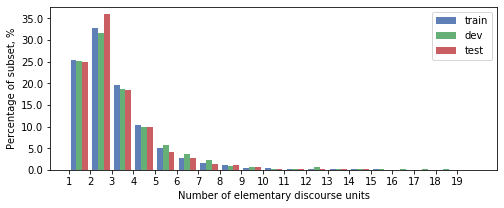

In [37]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-deep')
f = plt.figure(figsize=(8,3))

col = 'length_edu'
bins = np.linspace(1, 20, 20)

w_train = np.ones_like(train[col])/float(len(train[col]))
w_dev = np.ones_like(dev[col])/float(len(dev[col]))
w_test = np.ones_like(test[col])/float(len(test[col]))

plt.hist([train[col], dev[col], test[col]], 
         bins, density=False, alpha=.9, stacked=False, 
         weights=[w_train, w_dev, w_test], #rwidth=2.,
         label=['train', 'dev', 'test'], align='mid')
plt.legend(loc='upper right')
plt.xticks(range(1, 20))
plt.xlabel('Number of elementary discourse units')
plt.gca().set_yticklabels(['{:.1f}'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.ylabel('Percentage of subset, %')

f.savefig("length distribution.pdf", bbox_inches='tight')

In [71]:
train = train[train[col] < 10]

train_for = train[(train.masks_stance == 2) | (train.vaccines_stance == 2) | (train.quarantine_stance == 2)]
train_against = train[(train.masks_stance == 0) | (train.vaccines_stance == 0) | (train.quarantine_stance == 0)]
train_other = train[(train.masks_stance == 1) | (train.vaccines_stance == 1) | (train.quarantine_stance == 1)]

/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1426: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


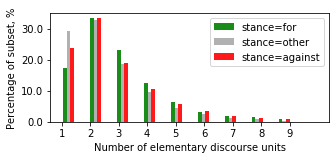

In [72]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-deep')
f = plt.figure(figsize=(5,2))

col = 'length_edu'
bins = np.linspace(1, 10, 20)

w_train_for = np.ones_like(train_for[col])/float(len(train_for[col]))
w_train_against = np.ones_like(train_against[col])/float(len(train_against[col]))
w_train_other = np.ones_like(train_other[col])/float(len(train_other[col]))

plt.hist([train_for[col], train_other[col], train_against[col]], 
         bins, density=False, alpha=.9, stacked=False, 
         weights=[w_train_for, w_train_other, w_train_against],
         label=['stance=for', 'stance=other', 'stance=against'], align='mid', color=['green', 'darkgrey', 'red'])
plt.legend(loc='upper right')
plt.xticks(range(1, 10))
plt.xlabel('Number of elementary discourse units')
plt.gca().set_yticklabels(['{:.1f}'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.ylabel('Percentage of subset, %')

f.savefig("length distribution by stance.pdf", bbox_inches='tight')

In [73]:
train_for = train[(train.masks_argument == 2) | (train.vaccines_argument == 2) | (train.quarantine_argument == 2)]
train_against = train[(train.masks_argument == 0) | (train.vaccines_argument == 0) | (train.quarantine_argument == 0)]
train_other = train[(train.masks_argument == 1) | (train.vaccines_argument == 1) | (train.quarantine_argument == 1)]

/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1426: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


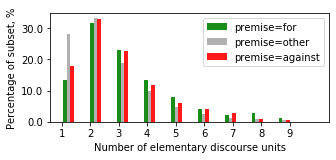

In [75]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-deep')
f = plt.figure(figsize=(5,2))

col = 'length_edu'
bins = np.linspace(1, 10, 20)

w_train_for = np.ones_like(train_for[col])/float(len(train_for[col]))
w_train_against = np.ones_like(train_against[col])/float(len(train_against[col]))
w_train_other = np.ones_like(train_other[col])/float(len(train_other[col]))

plt.hist([train_for[col], train_other[col], train_against[col]], 
         bins, density=False, alpha=.9, stacked=False, 
         weights=[w_train_for, w_train_other, w_train_against],
         label=['premise=for', 'premise=other', 'premise=against'], align='mid', color=['green', 'darkgrey', 'red'])
plt.legend(loc='upper right')
plt.xticks(range(1, 10))
plt.xlabel('Number of elementary discourse units')
plt.gca().set_yticklabels(['{:.1f}'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.ylabel('Percentage of subset, %')

f.savefig("length distribution by argument.pdf", bbox_inches='tight')

In [25]:
labels = ['attribution_NS', 'attribution_SN', 'background_NS',
          'cause-effect_NS', 'cause-effect_SN',
          'comparison_NN', 'concession_NS', 'condition_NS', 'condition_SN',
          'contrast_NN', 'elaboration_NS', 'evidence_NS',
          'interpretation-evaluation_NS', 'interpretation-evaluation_SN',
          'joint_NN', 'preparation_SN', 'purpose_NS', 'purpose_SN',
          'restatement_NN', 'same-unit_NN', 'sequence_NN', 'solutionhood_SN']


def extract_pairs(tree):
    result = []
    if tree.relation != 'elementary':
        result = [[tree.left.text, tree.right.text, tree.relation, tree.nuclearity]]
        result += extract_pairs(tree.left)
        result += extract_pairs(tree.right)
    return result

def discourse_relations(tree):
    pairs = extract_pairs(tree)
    result = dict()
    if pairs:
        for label in labels:
            relation = label.split('_')[0]
            if not relation + '_N' in result:
                for pair in pairs:
                    if pair[2] == relation:
                        if pair[3] == 'SN':
                            result[relation + '_S'] = pair[0]
                            result[relation + '_N'] = pair[1]
                        elif pair[3] == 'NS':
                            result[relation + '_S'] = pair[1]
                            result[relation + '_N'] = pair[0]
                        else:
                            result[relation + '_N'] = pair[0] + ' ' + pair[1]
    else:
        result['EDU'] = tree.text 
                    
    return result

In [141]:
train['rst_relations'] = train.annot.progress_map(lambda row: discourse_relations(row['rst'][0]))

100%|██████████| 6717/6717 [00:00<00:00, 82738.80it/s]


In [26]:
_all['rst_relations'] = _all.annot.progress_map(lambda row: discourse_relations(row['rst'][0]))

100%|██████████| 9550/9550 [00:00<00:00, 87121.15it/s]


In [142]:
n = 7
print(train.iloc[n]['text'])
train.iloc[n]['rst_relations']

[USER], надеемся, что в других регионах не придется вводить настолько жесткие меры по карантину


{'EDU': 'надеемся , что в других регионах не придется вводить настолько жесткие меры по карантину'}

In [ ]:
from isanlp.annotation_rst import ForestExporter

rs3exp = ForestExporter('utf8')
rs3exp(train.iloc[n]['annot']['rst'], 'вот_и_выходит.rs3')

In [144]:
def extract_pairs_forest(trees):
    result = []
    for tree in trees:
        result += extract_pairs(tree)
    return result

train['all_pairs'] = train.annot.progress_map(lambda row: extract_pairs_forest(row['rst']))

100%|██████████| 6717/6717 [00:00<00:00, 209376.99it/s]


In [ ]:
ar = [value for row in train['all_pairs'] for value in row]
all_relations = sorted(list(set([row[2] for row in ar])))

In [147]:
relations = train[train.masks_stance == 0].all_pairs.map(lambda row: [value[2] for value in row])

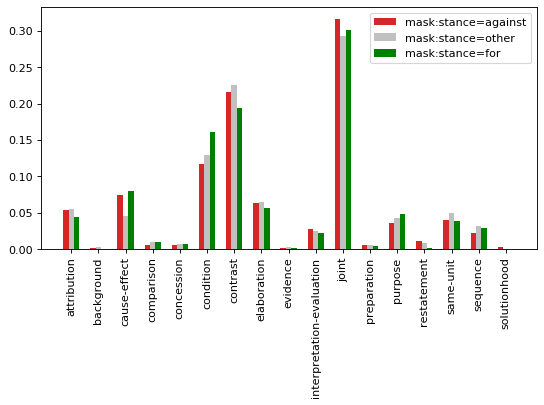

In [150]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.pyplot import figure


f = figure(figsize=(8, 4), dpi=80)

relations = train[train.masks_stance == 0].all_pairs.map(
    lambda row: [value[2] for value in row])
masks_stance_0 = [value for row in relations.values for value in row]
cntr = Counter(masks_stance_0)
values = [cntr.get(rel, 0) for rel in all_relations]
y_0 = [value / len(masks_stance_0) for value in values]

relations = train[train.masks_stance == 1].all_pairs.map(
    lambda row: [value[2] for value in row])
masks_stance_1 = [value for row in relations.values for value in row]
cntr = Counter(masks_stance_1)
values = [cntr.get(rel, 0) for rel in all_relations]
y_1 = [value / len(masks_stance_1) for value in values]

relations = train[train.masks_stance == 2].all_pairs.map(
    lambda row: [value[2] for value in row])
masks_stance_2 = [value for row in relations.values for value in row]
cntr = Counter(masks_stance_2)
values = [cntr.get(rel, 0) for rel in all_relations]
y_2 = [value / len(masks_stance_2) for value in values]

ax = plt.subplot(111)
indexes = np.arange(len(all_relations))
b0 = ax.bar(indexes-0.2, y_0, width=0.2, color='tab:red', align='center')
b1 = ax.bar(indexes, y_1, width=0.2, color='silver', align='center')
b2 = ax.bar(indexes+0.2, y_2, width=0.2, color='green', align='center')

ax.legend((b0, b1, b2), ('mask:stance=against', 'mask:stance=other', 'mask:stance=for'))
plt.xticks(indexes, all_relations, rotation=90)
plt.show()
f.savefig("disgraph_mask_stance.pdf", bbox_inches='tight')

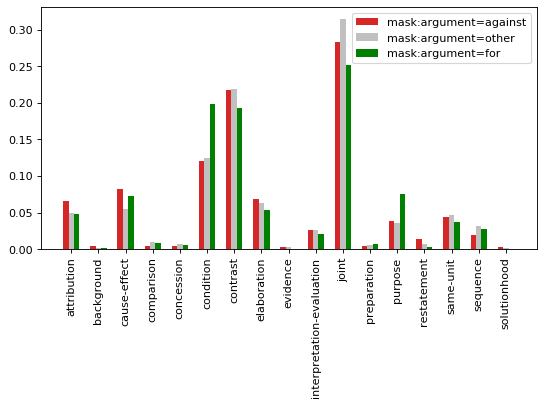

In [151]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.pyplot import figure


f = figure(figsize=(8, 4), dpi=80)

relations = train[train.masks_argument == 0].all_pairs.map(
    lambda row: [value[2] for value in row])
masks_stance_0 = [value for row in relations.values for value in row]
cntr = Counter(masks_stance_0)
values = [cntr.get(rel, 0) for rel in all_relations]
y_0 = [value / len(masks_stance_0) for value in values]

relations = train[train.masks_argument == 1].all_pairs.map(
    lambda row: [value[2] for value in row])
masks_stance_1 = [value for row in relations.values for value in row]
cntr = Counter(masks_stance_1)
values = [cntr.get(rel, 0) for rel in all_relations]
y_1 = [value / len(masks_stance_1) for value in values]

relations = train[train.masks_argument == 2].all_pairs.map(
    lambda row: [value[2] for value in row])
masks_stance_2 = [value for row in relations.values for value in row]
cntr = Counter(masks_stance_2)
values = [cntr.get(rel, 0) for rel in all_relations]
y_2 = [value / len(masks_stance_2) for value in values]

ax = plt.subplot(111)
indexes = np.arange(len(all_relations))
b0 = ax.bar(indexes-0.2, y_0, width=0.2, color='tab:red', align='center')
b1 = ax.bar(indexes, y_1, width=0.2, color='silver', align='center')
b2 = ax.bar(indexes+0.2, y_2, width=0.2, color='green', align='center')

ax.legend((b0, b1, b2), ('mask:argument=against', 'mask:argument=other', 'mask:argument=for'))
plt.xticks(indexes, all_relations, rotation=90)
plt.show()
f.savefig("disgraph_mask_argument.pdf", bbox_inches='tight')

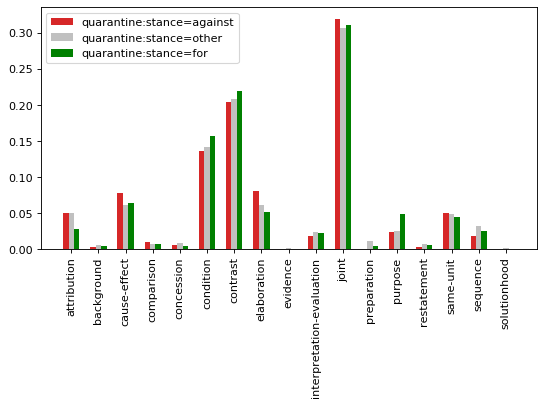

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.pyplot import figure


f = figure(figsize=(8, 4), dpi=80)

relations = train[train.quarantine_stance == 0].all_pairs.map(
    lambda row: [value[2] for value in row])
masks_stance_0 = [value for row in relations.values for value in row]
cntr = Counter(masks_stance_0)
values = [cntr.get(rel, 0) for rel in all_relations]
y_0 = [value / len(masks_stance_0) for value in values]

relations = train[train.quarantine_stance == 1].all_pairs.map(
    lambda row: [value[2] for value in row])
masks_stance_1 = [value for row in relations.values for value in row]
cntr = Counter(masks_stance_1)
values = [cntr.get(rel, 0) for rel in all_relations]
y_1 = [value / len(masks_stance_1) for value in values]

relations = train[train.quarantine_stance == 2].all_pairs.map(
    lambda row: [value[2] for value in row])
masks_stance_2 = [value for row in relations.values for value in row]
cntr = Counter(masks_stance_2)
values = [cntr.get(rel, 0) for rel in all_relations]
y_2 = [value / len(masks_stance_2) for value in values]

ax = plt.subplot(111)
indexes = np.arange(len(all_relations))
b0 = ax.bar(indexes-0.2, y_0, width=0.2, color='tab:red', align='center')
b1 = ax.bar(indexes, y_1, width=0.2, color='silver', align='center')
b2 = ax.bar(indexes+0.2, y_2, width=0.2, color='green', align='center')

ax.legend((b0, b1, b2), ('quarantine:stance=against', 'quarantine:stance=other', 'quarantine:stance=for'))
plt.xticks(indexes, all_relations, rotation=90)
plt.show()
f.savefig("disgraph_quarantine_stance.pdf", bbox_inches='tight')

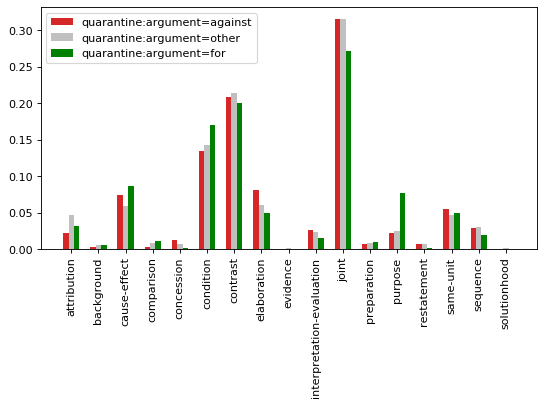

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.pyplot import figure


f = figure(figsize=(8, 4), dpi=80)

relations = train[train.quarantine_argument == 0].all_pairs.map(
    lambda row: [value[2] for value in row])
masks_stance_0 = [value for row in relations.values for value in row]
cntr = Counter(masks_stance_0)
values = [cntr.get(rel, 0) for rel in all_relations]
y_0 = [value / len(masks_stance_0) for value in values]

relations = train[train.quarantine_argument == 1].all_pairs.map(
    lambda row: [value[2] for value in row])
masks_stance_1 = [value for row in relations.values for value in row]
cntr = Counter(masks_stance_1)
values = [cntr.get(rel, 0) for rel in all_relations]
y_1 = [value / len(masks_stance_1) for value in values]

relations = train[train.quarantine_argument == 2].all_pairs.map(
    lambda row: [value[2] for value in row])
masks_stance_2 = [value for row in relations.values for value in row]
cntr = Counter(masks_stance_2)
values = [cntr.get(rel, 0) for rel in all_relations]
y_2 = [value / len(masks_stance_2) for value in values]

ax = plt.subplot(111)
indexes = np.arange(len(all_relations))
b0 = ax.bar(indexes-0.2, y_0, width=0.2, color='tab:red', align='center')
b1 = ax.bar(indexes, y_1, width=0.2, color='silver', align='center')
b2 = ax.bar(indexes+0.2, y_2, width=0.2, color='green', align='center')

ax.legend((b0, b1, b2), ('quarantine:argument=against', 'quarantine:argument=other', 'quarantine:argument=for'))
plt.xticks(indexes, all_relations, rotation=90)
plt.show()
f.savefig("disgraph_quarantine_argument.pdf", bbox_inches='tight')

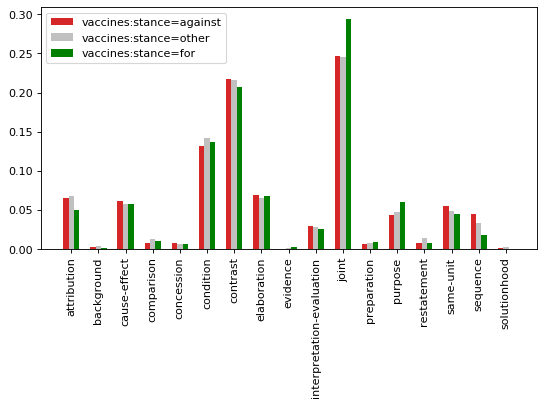

In [154]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.pyplot import figure


f = figure(figsize=(8, 4), dpi=80)

relations = train[train.vaccines_stance == 0].all_pairs.map(
    lambda row: [value[2] for value in row])
masks_stance_0 = [value for row in relations.values for value in row]
cntr = Counter(masks_stance_0)
values = [cntr.get(rel, 0) for rel in all_relations]
y_0 = [value / len(masks_stance_0) for value in values]

relations = train[train.vaccines_stance == 1].all_pairs.map(
    lambda row: [value[2] for value in row])
masks_stance_1 = [value for row in relations.values for value in row]
cntr = Counter(masks_stance_1)
values = [cntr.get(rel, 0) for rel in all_relations]
y_1 = [value / len(masks_stance_1) for value in values]

relations = train[train.vaccines_stance == 2].all_pairs.map(
    lambda row: [value[2] for value in row])
masks_stance_2 = [value for row in relations.values for value in row]
cntr = Counter(masks_stance_2)
values = [cntr.get(rel, 0) for rel in all_relations]
y_2 = [value / len(masks_stance_2) for value in values]

ax = plt.subplot(111)
indexes = np.arange(len(all_relations))
b0 = ax.bar(indexes-0.2, y_0, width=0.2, color='tab:red', align='center')
b1 = ax.bar(indexes, y_1, width=0.2, color='silver', align='center')
b2 = ax.bar(indexes+0.2, y_2, width=0.2, color='green', align='center')

ax.legend((b0, b1, b2), ('vaccines:stance=against', 'vaccines:stance=other', 'vaccines:stance=for'))
plt.xticks(indexes, all_relations, rotation=90)
plt.show()
f.savefig("disgraph_vaccines_stance.pdf", bbox_inches='tight')

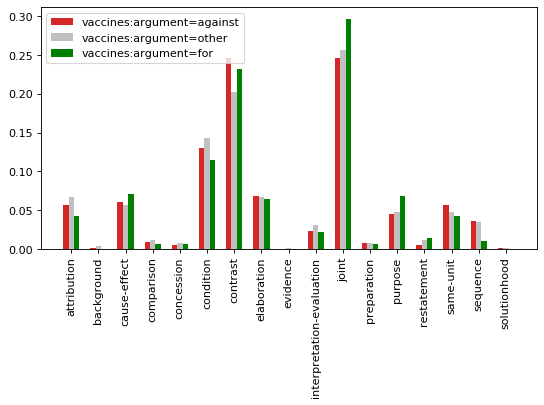

In [155]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.pyplot import figure


f = figure(figsize=(8, 4), dpi=80)

relations = train[train.vaccines_argument == 0].all_pairs.map(
    lambda row: [value[2] for value in row])
masks_stance_0 = [value for row in relations.values for value in row]
cntr = Counter(masks_stance_0)
values = [cntr.get(rel, 0) for rel in all_relations]
y_0 = [value / len(masks_stance_0) for value in values]

relations = train[train.vaccines_argument == 1].all_pairs.map(
    lambda row: [value[2] for value in row])
masks_stance_1 = [value for row in relations.values for value in row]
cntr = Counter(masks_stance_1)
values = [cntr.get(rel, 0) for rel in all_relations]
y_1 = [value / len(masks_stance_1) for value in values]

relations = train[train.vaccines_argument == 2].all_pairs.map(
    lambda row: [value[2] for value in row])
masks_stance_2 = [value for row in relations.values for value in row]
cntr = Counter(masks_stance_2)
values = [cntr.get(rel, 0) for rel in all_relations]
y_2 = [value / len(masks_stance_2) for value in values]

ax = plt.subplot(111)
indexes = np.arange(len(all_relations))
b0 = ax.bar(indexes-0.2, y_0, width=0.2, color='tab:red', align='center')
b1 = ax.bar(indexes, y_1, width=0.2, color='silver', align='center')
b2 = ax.bar(indexes+0.2, y_2, width=0.2, color='green', align='center')

ax.legend((b0, b1, b2), ('vaccines:argument=against', 'vaccines:argument=other', 'vaccines:argument=for'))
plt.xticks(indexes, all_relations, rotation=90)
plt.show()
f.savefig("disgraph_vaccines_argument.pdf", bbox_inches='tight')

### Actual statistics

In [156]:
train['rst_relations'] = train.all_pairs.map(lambda row: ' '.join([val[2] for val in row]))

In [173]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

relations_bow = CountVectorizer(tokenizer=lambda row: row.split(), ngram_range=(1,1))

relations_freq = relations_bow.fit_transform(train['rst_relations']).toarray()
X = pd.DataFrame(data=relations_freq, columns=relations_bow.get_feature_names())

In [175]:
X = X / X.sum(axis=1)[:,None]

/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


In [177]:
from sklearn.feature_selection import chi2

X = X.fillna(0).astype('float64')
scores, pvalues = chi2(X, train.masks_argument.values)
p_values = dict(zip(X.keys(), pvalues))
p_values = {k: v for k, v in sorted(p_values.items(), key=lambda item: item[0])}
print('\n'.join(map(lambda x: '{:e}'.format(x), p_values.values())))
{k: v for k, v in sorted(p_values.items(), key=lambda item: item[1])}

5.290067e-01
4.496092e-01
9.282537e-04
9.239274e-01
9.046907e-01
4.757876e-08
5.689361e-01
5.864945e-01
6.273123e-01
7.972416e-01
4.584164e-01
4.833212e-01
4.026860e-05
4.536836e-01
7.857519e-01
5.111001e-01
8.532170e-01


{'condition': 4.7578757563551366e-08,
 'purpose': 4.026859939730019e-05,
 'cause-effect': 0.0009282536991755733,
 'background': 0.44960921614962,
 'restatement': 0.45368361971757387,
 'joint': 0.4584163766191064,
 'preparation': 0.48332123304764096,
 'sequence': 0.5111000947577249,
 'attribution': 0.5290067061812824,
 'contrast': 0.5689361000103201,
 'elaboration': 0.5864945085285749,
 'evidence': 0.6273122788679732,
 'same-unit': 0.7857519249266336,
 'interpretation-evaluation': 0.7972415553041148,
 'solutionhood': 0.8532169597419509,
 'concession': 0.9046907240119558,
 'comparison': 0.9239273692595534}

In [182]:
scores, pvalues = chi2(X, train.masks_stance.values)
p_values = dict(zip(X.keys(), pvalues))
p_values = {k: v for k, v in sorted(p_values.items(), key=lambda item: item[0])}
print('\n'.join(map(lambda x: '{:e}'.format(x), p_values.values())))
{k: v for k, v in sorted(p_values.items(), key=lambda item: item[1])}

5.482537e-01
4.058508e-01
1.998747e-04
9.418320e-01
8.554066e-01
1.921699e-03
8.014754e-01
8.017153e-01
7.206419e-01
9.199794e-01
9.737347e-02
5.240888e-01
3.180201e-01
4.824476e-01
9.414478e-01
4.601998e-01
5.857219e-01


{'cause-effect': 0.00019987467749799244,
 'condition': 0.0019216987935382146,
 'joint': 0.09737347177770427,
 'purpose': 0.3180201357934089,
 'background': 0.40585080132488105,
 'sequence': 0.4601997588528599,
 'restatement': 0.4824476342211288,
 'preparation': 0.524088785609476,
 'attribution': 0.548253674888763,
 'solutionhood': 0.5857219193813552,
 'evidence': 0.7206419091655306,
 'contrast': 0.8014754247520969,
 'elaboration': 0.8017153136696208,
 'concession': 0.8554066175990572,
 'interpretation-evaluation': 0.919979352998915,
 'same-unit': 0.9414478407829785,
 'comparison': 0.9418320156495421}

In [184]:
scores, pvalues = chi2(X, train.vaccines_argument.values)
p_values = dict(zip(X.keys(), pvalues))
print('\n'.join(map(lambda x: '{:e}'.format(x), p_values.values())))
{k: v for k, v in sorted(p_values.items(), key=lambda item: item[1])}

2.459632e-02
8.604987e-01
3.554938e-01
9.086999e-01
5.331101e-01
8.945119e-01
3.101080e-01
8.503746e-01
6.681316e-01
9.376474e-01
2.385963e-02
9.215031e-01
5.674246e-02
3.096501e-02
7.759935e-01
6.840089e-01
9.325653e-01


{'joint': 0.023859626129013402,
 'attribution': 0.024596320843970104,
 'restatement': 0.03096501098325558,
 'purpose': 0.05674246395485286,
 'contrast': 0.3101079622978623,
 'cause-effect': 0.35549378255813124,
 'concession': 0.5331101362269999,
 'evidence': 0.6681316386898062,
 'sequence': 0.6840088841537251,
 'same-unit': 0.7759934734790395,
 'elaboration': 0.8503746159017148,
 'background': 0.8604987169591678,
 'condition': 0.8945118657743383,
 'comparison': 0.9086998958111526,
 'preparation': 0.9215030615739671,
 'solutionhood': 0.932565296457302,
 'interpretation-evaluation': 0.9376473921912701}

In [78]:
train.to_pickle('data/train_all_about_rst.pkl')

### Export discourse trees examples

In [22]:
from isanlp.annotation_rst import ForestExporter
import os

rs3exp = ForestExporter(encoding='utf8')

In [ ]:
! rm -r rst_result

In [ ]:
! mkdir rst_result

In [27]:
data.keys()

Index(['text_id', 'text', 'masks_stance', 'masks_argument',
       'quarantine_stance', 'quarantine_argument', 'vaccines_stance',
       'vaccines_argument', 'annot', 'tokens', 'rst_relations', 'all_pairs'],
      dtype='object')

In [101]:
! rm -r  rst_result/vaccines_stance

In [123]:
! ls rst_result/vaccines_argument

0  1  -1  2


In [121]:
data = pd.read_pickle('data/train_all_about_rst.pkl')
data = data[data.vaccines_argument == -1]
data.shape

(5059, 12)

In [114]:
! mkdir rst_result/vaccines_argument

mkdir: cannot create directory ‘rst_result/vaccines_argument’: File exists


In [122]:
pathname = 'rst_result/vaccines_argument/-1'
if not os.path.isdir(pathname):
    os.mkdir(pathname)
    
for idx, annot in data.annot.iteritems():
    rs3exp(annot['rst'], os.path.join(pathname, f'{idx}.rs3'))

In [126]:
! ls rst_result/quarantine_argument

0  1  -1  2


In [1]:
# ! zip -r rst_result.zip rst_result

In [140]:
lengths = data.annot.map(lambda row: len(row['rst']))

In [141]:
lengths.describe()

count    6717.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: annot, dtype: float64

In [18]:
print(data.annot.iloc[0]['rst'][0])

id: 4
text: согласно предписаниям Роспотребнадзора , все транзитные пассажиры , следующие через Москву , должны пройти 14-дневный карантин у себя по месту жительства .
proba: 1.0
relation: attribution
nuclearity: SN
left: согласно предписаниям Роспотребнадзора ,
right: все транзитные пассажиры , следующие через Москву , должны пройти 14-дневный карантин у себя по месту жительства .
start: 0
end: 155


In [19]:
len(data.annot.iloc[0]['rst'][0].text)

155